## Evaluating the `AnasAlokla/multilingual_go_emotions` model

this code is same eval_roberta_base_go_emotions code
with some differant

In [4]:
# %%capture --no-stderr
!pip install datasets transformers --upgrade --quiet

In [5]:
import datasets
from transformers import pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

### Load the dataset

We just want the dataset test split here for evaluation

In [6]:
split_name = "test"

dataset_name = "google-research-datasets/go_emotions"
dataset_dict = datasets.load_dataset(dataset_name)
#dataset = load_dataset('AnasAlokla/multilingual_go_emotions')
dataset_dict[split_name][0]

{'text': 'I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!',
 'labels': [25],
 'id': 'eecwqtt'}

In [7]:
# Print split sizes
for split in dataset_dict.keys():
    print(f"{split.capitalize()} set: {len(dataset_dict[split])} examples")

# View structure of a single example
print("\nExample structure:")
print(dataset_dict['train'][0])

Train set: 43410 examples
Validation set: 5426 examples
Test set: 5427 examples

Example structure:
{'text': "My favourite food is anything I didn't have to cook myself.", 'labels': [27], 'id': 'eebbqej'}


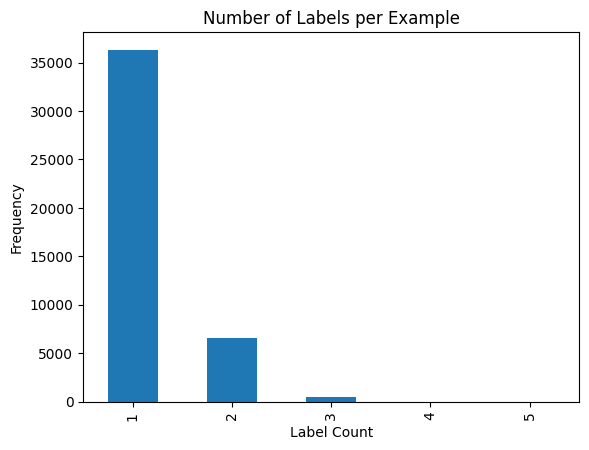

In [8]:
# Calculate number of labels per example
labels_per_example = [len(l) for l in dataset_dict['train']['labels']]
pd.Series(labels_per_example).value_counts().sort_index().plot(
    kind='bar', title='Number of Labels per Example', xlabel='Label Count', ylabel='Frequency'
)
plt.show()

Mean length: 68.4 chars
Max length: 703 chars


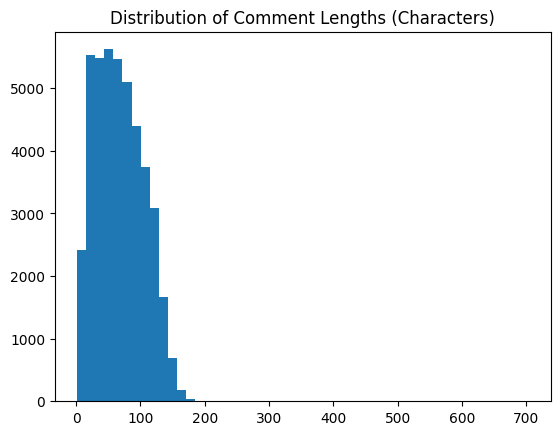

In [9]:
# Analyze character length
text_lengths = [len(t) for t in dataset_dict['train']['text'] if t]
print(f"Mean length: {np.mean(text_lengths):.1f} chars")
print(f"Max length: {np.max(text_lengths)} chars")

plt.hist(text_lengths, bins=50)
plt.title('Distribution of Comment Lengths (Characters)')
plt.show()

In [10]:
import ast

def convert_labels(example):
    # 1. Convert labels only if they are currently strings
    if isinstance(example.get('labels'), str):
        try:
            example['labels'] = ast.literal_eval(example['labels'])
        except (ValueError, SyntaxError):
            # Handle cases where the string might be empty or malformed
            example['labels'] = []
            
    # 2. Return the example (we will filter None values in the next step)
    return example

# Apply the conversion
dataset_dict = dataset_dict.map(convert_labels)

# Filter out rows where 'text' is None or 'labels' conversion failed
# This is more efficient than the manual loop for DatasetDict objects
dataset_dict = dataset_dict.filter(lambda x: x['text'] is not None)

# Check a sample from the first available split
first_split = list(dataset_dict.keys())[0]
print(f"Sample from {first_split}:", dataset_dict[first_split][0])

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

Filter:   0%|          | 0/43410 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5426 [00:00<?, ? examples/s]

Filter:   0%|          | 0/5427 [00:00<?, ? examples/s]

Sample from train: {'text': "My favourite food is anything I didn't have to cook myself.", 'labels': [27], 'id': 'eebbqej'}


In [11]:
labels_name=[
          "admiration",
          "amusement",
          "anger",
          "annoyance",
          "approval",
          "caring",
          "confusion",
          "curiosity",
          "desire",
          "disappointment",
          "disapproval",
          "disgust",
          "embarrassment",
          "excitement",
          "fear",
          "gratitude",
          "grief",
          "joy",
          "love",
          "nervousness",
          "optimism",
          "pride",
          "realization",
          "relief",
          "remorse",
          "sadness",
          "surprise",
          "neutral"
        ]

In [12]:
labels = labels_name
print({i: l for i, l in enumerate(labels)})

{0: 'admiration', 1: 'amusement', 2: 'anger', 3: 'annoyance', 4: 'approval', 5: 'caring', 6: 'confusion', 7: 'curiosity', 8: 'desire', 9: 'disappointment', 10: 'disapproval', 11: 'disgust', 12: 'embarrassment', 13: 'excitement', 14: 'fear', 15: 'gratitude', 16: 'grief', 17: 'joy', 18: 'love', 19: 'nervousness', 20: 'optimism', 21: 'pride', 22: 'realization', 23: 'relief', 24: 'remorse', 25: 'sadness', 26: 'surprise', 27: 'neutral'}


Load into a `y_target` stucture of arrays by label (since we wish to evaluate per label for a multi-label, multi-class dataset like this)

In [13]:
num_items, num_labels = len(dataset_dict[split_name]), len(labels)
y_targets_all = np.zeros((num_items, num_labels), dtype=int)
for i, labels_indices in enumerate(dataset_dict[split_name]["labels"]):
    for label_index in labels_indices:
        y_targets_all[i, label_index] = 1

print(y_targets_all[0:3])

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


### Load the model and run it

Loading in a multi-label, multi-class classifier model based on Roberta-base

In [14]:
model_name='AnasAlokla/multilingual_go_emotions_V1.2'
classifier = pipeline(task="text-classification", model=model_name, top_k=None, truncation=True, max_length=128)

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/712M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

Very simple to then run the pipeline on the dataset test split.
- c.5k items so can be run on a decent CPU in a few minutes (E.g. 3.5 mins on a 11th gen i7 laptop)
- (will take signifcantly longer on a free Colab instance's 2 core CPU)
- or of course via a GPU in seconds.

In [15]:
# 1. Clean the text list to ensure NO None values and ONLY strings
# This prevents the ValueError by ensuring every item is a valid string
clean_texts = [str(t) for t in dataset_dict[split_name]["text"] if t is not None]

# 2. Run the classifier on the cleaned list
# Use a generator or list to handle the batch processing correctly
model_outputs = classifier(clean_texts, batch_size=32)

# 3. Populate y_probas_all using the results
y_probas_all = np.zeros((len(clean_texts), num_labels), dtype=float)

for i, item_probas in enumerate(model_outputs):
    for item_proba in item_probas:
        label, score = item_proba["label"], item_proba["score"]
        if label in labels:
            label_index = labels.index(label)
            y_probas_all[i, label_index] = score

The model gave us floating point outputs for each label for each item, as a list of dicts. We need to arrange these into an array to be able to easily compare them with the dataset values. These values are sometimes known as probabilities (or `probas` for short) - but note, although these values are quantitative and can be compared to an extent (as we will), they are not really probabilities in any real statistical sense.

We still need to convert these to binary prediction (`preds`) to be able to compare them to the `y_target` values from the dataset, but since the best threshold value to use to convert them is not yet known, we'll keep the float values.

In [16]:
i = 3856
print(dataset_dict[split_name][i])
print(np.round(y_probas_all[i], 3).tolist())
top = np.argmax(y_probas_all[i])
print(f"Top label proba is label number {top} ({labels[top]}): {y_probas_all[i][top]}")

{'text': 'Damn, still hoping...', 'labels': [20], 'id': 'edm34qc'}
[0.0, 0.0, 0.019, 0.004, 0.0, 0.0, 0.0, 0.0, 0.001, 0.001, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004, 0.0, 0.0, 0.0, 0.008, 0.998, 0.0, 0.0, 0.0, 0.0, 0.001, 0.0, 0.001]
Top label proba is label number 20 (optimism): 0.9978626370429993


### Evalutation

In [31]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, f1_score
from tqdm import tqdm

# 1. Dynamic Label Mapping
# Safely get labels from the dataset features so indices always match
labels = dataset_dict['train'].features['labels'].feature.names
label2id = {l: i for i, l in enumerate(labels)}
num_labels = len(labels)

print(f"Loaded {num_labels} labels from dataset features.")

# 2. Robust Prediction Function (Corrected)
def get_probas_and_targets(split_name):
    """
    Runs inference on a specific split and returns aligned
    probabilities (X) and one-hot targets (y).
    """
    print(f"Processing {split_name} set...")
    # Filter valid items only
    data = dataset_dict[split_name].filter(lambda x: x['text'] is not None)
    
    texts = [str(t) for t in data["text"]]
    
    # Convert list of label indices to one-hot matrix
    targets = np.zeros((len(texts), num_labels), dtype=int)
    for i, label_indices in enumerate(data["labels"]):
        for label_idx in label_indices:
            targets[i, label_idx] = 1

    # Run Model
    outputs = classifier(texts, batch_size=32)

    # Convert model outputs (list of dicts) to probability matrix
    probas = np.zeros((len(texts), num_labels), dtype=float)
    for i, out in enumerate(outputs):
        for pred in out:
            # map label string back to integer index
            l_id = label2id.get(pred['label'])
            if l_id is not None:
                probas[i, l_id] = pred['score']
                
    return probas, targets

# ---------------------------------------------------------
# STEP 3: Run Inference on BOTH Validation and Test splits
# ---------------------------------------------------------

# We use Validation to tune thresholds
val_probas, val_targets = get_probas_and_targets("validation")

# We use Test ONLY for the final report
test_probas, test_targets = get_probas_and_targets("test")

# ---------------------------------------------------------
# STEP 4: Tune Thresholds on Validation Set
# ---------------------------------------------------------
print("\nTuning thresholds on Validation set...")
best_thresholds = np.full(num_labels, 0.5) # Default to 0.5

# Search space for thresholds
thresholds_to_try = np.arange(0.1, 0.95, 0.05)

for i, label in enumerate(tqdm(labels, desc="Optimizing per label")):
    y_true = val_targets[:, i]
    
    # Skip labels with no positive examples in validation to avoid errors
    if y_true.sum() == 0:
        continue
        
    best_f1 = 0
    best_t = 0.5
    
    # Try different thresholds for this specific label
    val_scores = val_probas[:, i]
    for t in thresholds_to_try:
        y_pred = (val_scores >= t).astype(int)
        # Calculate F1 (binary) for this label
        score = f1_score(y_true, y_pred, zero_division=0)
        if score > best_f1:
            best_f1 = score
            best_t = t
            
    best_thresholds[i] = best_t

# ---------------------------------------------------------
# STEP 5: Final Evaluation on Test Set
# ---------------------------------------------------------
print("\nApplying optimized thresholds to Test set...")

# Apply the thresholds found in Step 4 to the Test probabilities
test_preds = np.zeros_like(test_probas, dtype=int)
for i in range(num_labels):
    test_preds[:, i] = (test_probas[:, i] >= best_thresholds[i]).astype(int)

# Generate detailed report
print("\nFinal Test Set Evaluation:")
print("==========================")
report = classification_report(
    test_targets, 
    test_preds, 
    target_names=labels, 
    zero_division=0
)
print(report)

# Optional: Show the thresholds we learned
print("\nLearned Optimal Thresholds:")
threshold_df = pd.DataFrame({
    'Label': labels,
    'Optimized_Threshold': best_thresholds
})
display(threshold_df.T)

Loaded 28 labels from dataset features.
Processing validation set...
Processing test set...


Filter:   0%|          | 0/5427 [00:00<?, ? examples/s]


Tuning thresholds on Validation set...


Optimizing per label: 100%|██████████| 28/28 [00:00<00:00, 32.19it/s]


Applying optimized thresholds to Test set...

Final Test Set Evaluation:
                precision    recall  f1-score   support

    admiration       0.93      0.84      0.88       504
     amusement       0.94      0.94      0.94       264
         anger       0.89      0.75      0.81       198
     annoyance       0.69      0.76      0.72       320
      approval       0.76      0.78      0.77       351
        caring       0.84      0.70      0.77       135
     confusion       0.86      0.79      0.83       153
     curiosity       0.88      0.82      0.85       284
        desire       0.95      0.73      0.83        83
disappointment       0.78      0.61      0.68       151
   disapproval       0.88      0.72      0.79       267
       disgust       0.94      0.72      0.82       123
 embarrassment       0.87      0.70      0.78        37
    excitement       0.75      0.80      0.77       103
          fear       0.84      0.91      0.87        78
     gratitude       0.97    

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
Label,admiration,amusement,anger,annoyance,approval,caring,confusion,curiosity,desire,disappointment,...,love,nervousness,optimism,pride,realization,relief,remorse,sadness,surprise,neutral
Optimized_Threshold,0.6,0.6,0.75,0.3,0.35,0.45,0.65,0.6,0.85,0.5,...,0.7,0.5,0.5,0.55,0.45,0.6,0.2,0.5,0.4,0.5


In [32]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, f1_score
from tqdm import tqdm

# Ensure labels are loaded
labels = dataset_dict['train'].features['labels'].feature.names
label2id = {l: i for i, l in enumerate(labels)}
num_labels = len(labels)

# Robust Prediction Function (with string conversion fix)
def get_probas_and_targets(split_name):
    print(f"Processing {split_name} set...")
    # Filter valid items
    data = dataset_dict[split_name].filter(lambda x: x['text'] is not None)
    
    # FIX: Explicitly convert to Python strings to prevent ValueError
    texts = [str(t) for t in data["text"]]
    
    # Create one-hot targets
    targets = np.zeros((len(texts), num_labels), dtype=int)
    for i, label_indices in enumerate(data["labels"]):
        for label_idx in label_indices:
            targets[i, label_idx] = 1

    # Run Model Inference
    outputs = classifier(texts, batch_size=32)

    # Convert to probability matrix
    probas = np.zeros((len(texts), num_labels), dtype=float)
    for i, out in enumerate(outputs):
        for pred in out:
            l_id = label2id.get(pred['label'])
            if l_id is not None:
                probas[i, l_id] = pred['score']
                
    return probas, targets

# ---------------------------------------------------------
# STEP 1: Tune Thresholds on Validation Set (Standard Practice)
# ---------------------------------------------------------
val_probas, val_targets = get_probas_and_targets("validation")

print("\nTuning thresholds on Validation set...")
best_thresholds = np.full(num_labels, 0.5) 
thresholds_to_try = np.arange(0.1, 0.95, 0.05)

for i, label in enumerate(tqdm(labels, desc="Optimizing thresholds")):
    y_true = val_targets[:, i]
    if y_true.sum() == 0: continue
        
    best_f1 = 0
    best_t = 0.5
    
    val_scores = val_probas[:, i]
    for t in thresholds_to_try:
        y_pred = (val_scores >= t).astype(int)
        score = f1_score(y_true, y_pred, zero_division=0)
        if score > best_f1:
            best_f1 = score
            best_t = t     
    best_thresholds[i] = best_t

# ---------------------------------------------------------
# STEP 2: Evaluate on TRAINING Set
# ---------------------------------------------------------
print("\nRunning inference on TRAINING set")
train_probas, train_targets = get_probas_and_targets("train")

print("\nApplying validation thresholds to Training set")
train_preds = np.zeros_like(train_probas, dtype=int)
for i in range(num_labels):
    train_preds[:, i] = (train_probas[:, i] >= best_thresholds[i]).astype(int)

print("\nFinal Training Set Evaluation:")
print("==============================")
print(classification_report(
    train_targets, 
    train_preds, 
    target_names=labels, 
    zero_division=0
))

Processing validation set...

Tuning thresholds on Validation set...


Optimizing thresholds: 100%|██████████| 28/28 [00:00<00:00, 31.69it/s]


Running inference on TRAINING set (this may take time)...
Processing train set...


Filter:   0%|          | 0/43410 [00:00<?, ? examples/s]


Applying validation thresholds to Training set...

Final Training Set Evaluation:
                precision    recall  f1-score   support

    admiration       0.94      0.84      0.89      4130
     amusement       0.91      0.93      0.92      2328
         anger       0.88      0.75      0.81      1567
     annoyance       0.70      0.75      0.72      2470
      approval       0.77      0.77      0.77      2939
        caring       0.82      0.77      0.79      1087
     confusion       0.87      0.75      0.80      1368
     curiosity       0.89      0.82      0.85      2191
        desire       0.91      0.76      0.83       641
disappointment       0.83      0.68      0.75      1269
   disapproval       0.90      0.70      0.79      2022
       disgust       0.90      0.72      0.80       793
 embarrassment       0.89      0.75      0.81       303
    excitement       0.74      0.81      0.78       853
          fear       0.83      0.89      0.86       596
     gratitude      